In [ ]:
import torch
import numpy as np
import os
import cma
from eval import play
from gan.config import SmallModelConfig
from gan.models.small_models import Generator
from play_rl.zelda_astar import play_astar
from gan.utils import tensor_to_level_str,check_playable
from gan.level_visualizer import GVGAILevelVisualizer
from gan.env import Env
from play_rl.wrappers import GridGame
from play_rl.policy import Policy
from PIL import Image

In [ ]:
config = SmallModelConfig()
config.set_env()
config.cuda = False
if config.cuda:
    device = torch.device(
        "cuda" if torch.cuda.is_available else "cpu")
    print("device : cuda")
else:
    device = torch.device("cpu")
    print("device : cpu")
generator = Generator(
    out_ch=config.input_shape[0],
    shapes=config.model_shapes,
    z_shape=(config.latent_size,),
    filters=config.generator_filters,
    use_linear4z2features_g=config.use_linear4z2features_g,
    use_self_attention=config.use_self_attention_g,
    use_conditional=config.use_conditional,
    use_deconv_g=config.use_deconv_g
).to(device)

env_def = Env(config.env_name,config.env_version)
level_visualizer = GVGAILevelVisualizer(env=env_def)

# model_path = os.path.join(
#     "/root/mnt/GVGAI-GAN/gan/checkpoints/_ours-152", "models_3800.tar")
# model_path = os.path.join(
#     "/root/mnt/GVGAI-GAN/gan/checkpoints/_boot_baseline-161", "models_3500.tar")
# model_path = os.path.join(
#     '/root/mnt/GVGAI-GAN/gan/checkpoints/_only5-121','models_1240.tar'
# )

# model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/_only5/models_10000.tar"
# model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/_baseline-boot-371/latest.tar"
# model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/_ours1-366/models_3000.tar"
# model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/_ours2-369/models_1660.tar"

# only5
# 

# baseline
# model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/none-700/latest.tar"

# # ours1
# model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/none-706/latest.tar"

# # ours2
model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/none-714/latest.tar"
# model_dict = torch.load(model_path)


load_model = torch.load(model_path)
generator.load_state_dict(load_model["generator"])
x = torch.randn(config.latent_size).to(device)


In [ ]:
def f1(level_str):
    wall = 0
    enemy = 0
    for i, s in enumerate(level_str):
        for j, c in enumerate(s):
            if c == 'w':
                wall += 1
            if c in ['1', '2', '3']:
                enemy += 1
    return - wall - 5 * enemy


def f2(level_str):
    wall = 0
    enemy = 0
    for i, s in enumerate(level_str):
        for j, c in enumerate(s):
            if c == 'w':
                wall += 1
            if c in ['1', '2', '3']:
                enemy += 1
    return wall + 5 * enemy

# # env = GridGame(config.env_name, 200, env_def.state_shape)
# # actor = Policy(env.observation_space.shape, env.action_space,base_kwargs={"recurrent": True})
# # actor.load_state_dict(torch.load('/root/mnt/GVGAI-GAN/play_rl/checkpoints/ppo/zelda_20220825102126.pt'))

def fitnessf1(x: torch.Tensor):
    x = np.array(x)
    latent = torch.FloatTensor(x).view(1, -1, 1, 1)
    level = generator(latent)
    level_str = tensor_to_level_str('zelda', level)
    playable = check_playable(level_str[0],config.env_fullname)
    if not playable:
        return 100
    # reward,step,_ = play(level_str[0],env=env,actor=actor)
    # reward, step, _ = play_astar(level_str[0], env=env)

    # return -(reward*100+step)
    ev = f1(level_str)
    return ev


def fitnessf2(x: torch.Tensor):
    x = np.array(x)
    latent = torch.FloatTensor(x).view(1, -1, 1, 1)
    level = generator(latent)
    level_str = tensor_to_level_str('zelda', level)
    playable = check_playable(level_str[0], config.env_fullname)
    if not playable:
        return 100
    # reward,step,_ = play(level_str[0],env=env,actor=actor)
    # reward, step, _ = play_astar(level_str[0], env=env)

    # return -(reward*100+step)
    ev = f2(level_str)
    return ev

def show(x):
    p_level = torch.nn.Softmax2d()(generator(x))
    level_strs = tensor_to_level_str(
        config.env_name, p_level)
    p_level_img = np.array(level_visualizer.draw_level(level_strs[0]))
    image = Image.fromarray(p_level_img)
    image.show()


def show2(x,x2):
    p_level = torch.nn.Softmax2d()(generator(x))
    level_strs = tensor_to_level_str(
        config.env_name, p_level)
    p_level_img1 = np.array(level_visualizer.draw_level(level_strs[0]))
    p_level = torch.nn.Softmax2d()(generator(x2))
    level_strs = tensor_to_level_str(
        config.env_name, p_level)
    p_level_img2 = np.array(level_visualizer.draw_level(level_strs[0]))
    concated = np.concatenate([p_level_img1,p_level_img2],axis=1)
    image = Image.fromarray(concated)
    image.show()

    
x = torch.randn(config.latent_size).to(device)
es = cma.CMAEvolutionStrategy(x.tolist(), 0.5)
# es.optimize(fitness,iterations=30,min_iterations=30)
es.optimize(fitnessf1,min_iterations=150,max_iterations=150)
best = np.array(es.best.get()[0])
print("INIT: ", np.array(x.tolist()))
print("BEST: ", best)
print("Fitness: ", fitnessf1(best))
# show(x)
# show(torch.FloatTensor(best))
show2(x,torch.FloatTensor(best))

# # sum = 0
# # N = 10
# # for i in range(N):
# #     x = torch.randn(config.latent_size).to(device)
# #     es = cma.CMAEvolutionStrategy(x.tolist(), 0.5)
# #     es.optimize(fitness)
# #     best = np.array(es.best.get()[0])
# #     sum += fitness(best)

# # print("mean:",best/N)


In [ ]:
def check(generator,fitness):
    scores = []

    wall_and_enemy_scores = []
    wall_and_enemy_changes = []

    playables = []
    playable_levels = []
    def check_level_hamming(level1: str, level2: str):
        hit = 0
        for c1, c2 in zip(level1, level2):
            if c1 == "\n":
                continue
            if c1 != c2:
                hit += 1
        return hit

    def count_wall_and_enemy(level_str: str):
        hit = 0
        for j, c in enumerate(level_str):
            if c == 'w':
                hit += 1
            if c in ['1', '2', '3']:
                hit += 5
        return hit

    for i in range(50):
        x = torch.randn(config.latent_size).to(device)
        es = cma.CMAEvolutionStrategy(x.tolist(),0.5)
        es.optimize(fitness,iterations=150,min_iterations=150)
        
        # es.optimize(fitness)
        best = np.array(es.best.get()[0])
        level_first = generator(x)
        level_str_first = tensor_to_level_str('zelda',level_first)
        wall_and_enemy_first = count_wall_and_enemy(level_str_first[0])

        level_target = generator(torch.FloatTensor(best))
        level_str_target = tensor_to_level_str('zelda', level_target)
        wall_and_enemy_target = count_wall_and_enemy(level_str_target[0])

        playable = check_playable(level_str_target[0], config.env_fullname)
        playables.append(1 if playable else 0)
        if playable:
            scores.append(fitness(best))
            wall_and_enemy_scores.append(wall_and_enemy_target)
            wall_and_enemy_changes.append(wall_and_enemy_target-wall_and_enemy_first)
            playable_levels.append(level_str_target[0])
        show(torch.FloatTensor(best))

    hamming_dist_sum = 0
    n = 0
    for i in range(len(playable_levels)):
        for j in range(len(playable_levels)):
            if i==j: 
                continue
            hamming_dist_sum += check_level_hamming(playable_levels[i], playable_levels[j])
            n+=1

    print(f"mean score:{np.array(scores).mean()}")
    print(f"mean counts:{np.array(wall_and_enemy_scores).mean()}")
    print(f"mean changes:{np.array(wall_and_enemy_changes).mean()}")
    print(f"mean playability:{np.array(playables).mean()}")
    print(f"mean hamming dist:{hamming_dist_sum/n}")
    

In [ ]:
# baseline
model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/none-700/latest.tar"
load_model = torch.load(model_path)
generator.load_state_dict(load_model["generator"])
check(generator, fitnessf1)


In [ ]:
# baseline
model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/none-700/latest.tar"
load_model = torch.load(model_path)
generator.load_state_dict(load_model["generator"])
check(generator, fitnessf2)

In [ ]:
# ours2
model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/none-714/latest.tar"
load_model = torch.load(model_path)
generator.load_state_dict(load_model["generator"])

check(generator,fitnessf1)


(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1153075, Wed Nov  9 08:35:37 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 9.200000000000000e+01 1.0e+00 4.68e-01  5e-01  5e-01 0:00.1
    2     28 8.500000000000000e+01 1.1e+00 4.61e-01  5e-01  5e-01 0:00.3
    3     42 8.600000000000000e+01 1.1e+00 4.59e-01  5e-01  5e-01 0:00.4
   29    406 6.700000000000000e+01 1.7e+00 6.61e-01  6e-01  7e-01 0:03.5
   60    840 6.100000000000000e+01 2.4e+00 8.71e-01  8e-01  1e+00 0:07.5
   82   1148 6.000000000000000e+01 2.6e+00 6.84e-01  6e-01  8e-01 0:10.1
   83   1162 6.000000000000000e+01 2.6e+00 6.81e-01  6e-01  8e-01 0:10.2
   86   1204 6.000000000000000e+01 2.7e+00 7.02e-01  7e-01  8e-01 0:10.5
   87   1218 6.000000000000000e+01 2.7e+00 6.99e-01  7e-01  8e-01 0:10.7
   94   1316 6.000000000000000e+01 2.7e+00 6.74e-01  6e-01  8e-01 0:11.5
   95   1330 6.000000000000000e+01 2.7e+00 6.88e-01  7e-01  8e-01 0:11.6
   98   1372 6.000000000000000e+

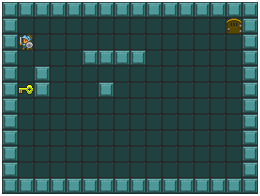

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1011187, Wed Nov  9 08:35:57 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 9.600000000000000e+01 1.0e+00 4.70e-01  5e-01  5e-01 0:00.1
    2     28 8.400000000000000e+01 1.1e+00 4.55e-01  4e-01  5e-01 0:00.3
    3     42 8.900000000000000e+01 1.1e+00 4.40e-01  4e-01  4e-01 0:00.4
   31    434 6.400000000000000e+01 1.5e+00 4.32e-01  4e-01  5e-01 0:03.4
   62    868 6.100000000000000e+01 1.9e+00 5.38e-01  5e-01  6e-01 0:07.5
  100   1400 6.100000000000000e+01 2.5e+00 4.64e-01  4e-01  5e-01 0:11.9
  115   1610 6.100000000000000e+01 2.6e+00 3.52e-01  3e-01  4e-01 0:13.8
  116   1624 6.100000000000000e+01 2.6e+00 3.42e-01  3e-01  4e-01 0:13.9
  117   1638 6.100000000000000e+01 2.7e+00 3.31e-01  3e-01  4e-01 0:14.0
  118   1652 6.100000000000000e+01 2.7e+00 3.26e-01  3e-01  4e-01 0:14.1
  119   1666 6.100000000000000e+01 2.7e+00 3.28e-01  3e-01  4e-01 0:14.3
  120   1680 6.100000000000000e+

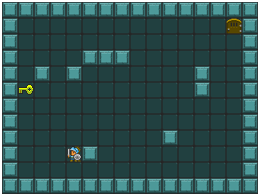

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1089484, Wed Nov  9 08:36:15 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.600000000000000e+01 1.0e+00 4.80e-01  5e-01  5e-01 0:00.1
    2     28 8.600000000000000e+01 1.1e+00 4.69e-01  5e-01  5e-01 0:00.3
    3     42 8.300000000000000e+01 1.1e+00 4.62e-01  5e-01  5e-01 0:00.3
   32    448 6.700000000000000e+01 1.7e+00 7.18e-01  7e-01  8e-01 0:03.4
   66    924 5.800000000000000e+01 2.1e+00 9.97e-01  9e-01  1e+00 0:07.5
  100   1400 5.600000000000000e+01 2.6e+00 7.21e-01  7e-01  1e+00 0:11.1
  125   1750 5.600000000000000e+01 3.2e+00 6.64e-01  6e-01  1e+00 0:13.8
  126   1764 5.600000000000000e+01 3.2e+00 6.43e-01  6e-01  1e+00 0:14.0
  127   1778 5.600000000000000e+01 3.2e+00 6.22e-01  6e-01  9e-01 0:14.1
  128   1792 5.600000000000000e+01 3.2e+00 6.07e-01  5e-01  9e-01 0:14.2
  129   1806 5.600000000000000e+01 3.2e+00 6.11e-01  5e-01  9e-01 0:14.4
  130   1820 5.600000000000000e+

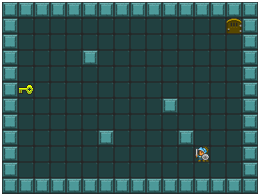

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1089678, Wed Nov  9 08:36:32 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.69e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.48e-01  4e-01  5e-01 0:00.3
    3     42 1.000000000000000e+02 1.1e+00 4.30e-01  4e-01  4e-01 0:00.4
    4     56 1.000000000000000e+02 1.1e+00 4.17e-01  4e-01  4e-01 0:00.5
    5     70 1.000000000000000e+02 1.1e+00 4.17e-01  4e-01  4e-01 0:00.7
    6     84 1.000000000000000e+02 1.1e+00 4.13e-01  4e-01  4e-01 0:00.8
    7     98 1.000000000000000e+02 1.1e+00 4.12e-01  4e-01  4e-01 0:00.9
    8    112 1.000000000000000e+02 1.2e+00 4.19e-01  4e-01  4e-01 0:01.0
    9    126 1.000000000000000e+02 1.2e+00 4.24e-01  4e-01  4e-01 0:01.2
   10    140 1.000000000000000e+02 1.2e+00 4.22e-01  4e-01  4e-01 0:01.3
   11    154 1.000000000000000e+02 1.2e+00 4.30e-01  4e-01  4e-01 0:01.4
   14    196 1.000000000000000e+

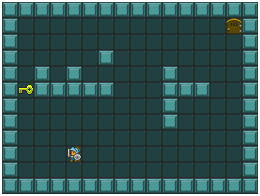

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1111433, Wed Nov  9 08:36:50 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.67e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.45e-01  4e-01  4e-01 0:00.3
    3     42 1.000000000000000e+02 1.1e+00 4.32e-01  4e-01  4e-01 0:00.4
   26    364 7.600000000000000e+01 1.5e+00 4.21e-01  4e-01  4e-01 0:03.4
   63    882 6.800000000000000e+01 1.8e+00 2.96e-01  3e-01  3e-01 0:07.5
   98   1372 6.700000000000000e+01 2.2e+00 1.46e-01  1e-01  2e-01 0:11.5
  100   1400 6.700000000000000e+01 2.2e+00 1.41e-01  1e-01  2e-01 0:11.7
  107   1498 6.700000000000000e+01 2.2e+00 1.30e-01  1e-01  1e-01 0:12.5
  108   1512 6.700000000000000e+01 2.2e+00 1.29e-01  1e-01  1e-01 0:12.6
  109   1526 6.700000000000000e+01 2.3e+00 1.26e-01  1e-01  1e-01 0:12.7
  110   1540 6.700000000000000e+01 2.3e+00 1.27e-01  1e-01  1e-01 0:12.9
  111   1554 6.700000000000000e+

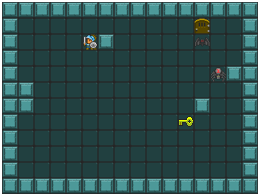

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1138107, Wed Nov  9 08:37:07 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.300000000000000e+01 1.0e+00 4.69e-01  5e-01  5e-01 0:00.1
    2     28 8.800000000000000e+01 1.1e+00 4.45e-01  4e-01  4e-01 0:00.3
    3     42 1.000000000000000e+02 1.1e+00 4.29e-01  4e-01  4e-01 0:00.4
   31    434 6.800000000000000e+01 1.6e+00 4.49e-01  4e-01  5e-01 0:03.4
   63    882 6.100000000000000e+01 2.2e+00 6.70e-01  6e-01  8e-01 0:07.5
  100   1400 5.600000000000000e+01 2.4e+00 7.09e-01  6e-01  8e-01 0:11.8
  137   1918 5.600000000000000e+01 2.8e+00 6.25e-01  5e-01  8e-01 0:17.1
  146   2044 5.600000000000000e+01 2.9e+00 5.28e-01  5e-01  7e-01 0:18.1
  147   2058 5.600000000000000e+01 2.9e+00 5.17e-01  4e-01  6e-01 0:18.2
  148   2072 5.600000000000000e+01 2.9e+00 5.15e-01  4e-01  6e-01 0:18.3
  149   2086 5.600000000000000e+01 3.0e+00 5.17e-01  4e-01  6e-01 0:18.4
  150   2100 5.600000000000000e+

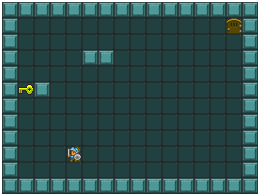

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1122942, Wed Nov  9 08:37:26 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.65e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.45e-01  4e-01  4e-01 0:00.3
    3     42 9.400000000000000e+01 1.1e+00 4.30e-01  4e-01  4e-01 0:00.4
   32    448 6.500000000000000e+01 1.6e+00 4.09e-01  4e-01  4e-01 0:03.4
   66    924 6.200000000000000e+01 2.1e+00 4.19e-01  4e-01  5e-01 0:07.5
   90   1260 6.200000000000000e+01 2.4e+00 2.72e-01  2e-01  3e-01 0:10.1
  100   1400 6.200000000000000e+01 2.5e+00 2.00e-01  2e-01  2e-01 0:11.3
  101   1414 6.200000000000000e+01 2.5e+00 2.01e-01  2e-01  2e-01 0:11.4
  102   1428 6.200000000000000e+01 2.5e+00 1.98e-01  2e-01  2e-01 0:11.6
  105   1470 6.200000000000000e+01 2.6e+00 1.94e-01  2e-01  2e-01 0:11.9
  106   1484 6.200000000000000e+01 2.6e+00 1.93e-01  2e-01  2e-01 0:12.0
  107   1498 6.200000000000000e+

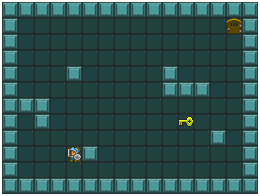

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1096827, Wed Nov  9 08:37:44 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.71e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.49e-01  4e-01  5e-01 0:00.3
    3     42 1.000000000000000e+02 1.1e+00 4.46e-01  4e-01  5e-01 0:00.4
   34    476 6.700000000000000e+01 2.0e+00 8.51e-01  8e-01  1e+00 0:03.4
   68    952 5.900000000000000e+01 2.3e+00 1.27e+00  1e+00  2e+00 0:07.4
  100   1400 5.800000000000000e+01 2.9e+00 9.31e-01  9e-01  1e+00 0:11.4
  125   1750 5.800000000000000e+01 3.1e+00 9.19e-01  8e-01  1e+00 0:14.1
  126   1764 5.800000000000000e+01 3.1e+00 9.12e-01  8e-01  1e+00 0:14.4
  127   1778 5.800000000000000e+01 3.1e+00 9.11e-01  8e-01  1e+00 0:14.6
  130   1820 5.800000000000000e+01 3.1e+00 8.40e-01  7e-01  1e+00 0:15.1
  131   1834 5.800000000000000e+01 3.1e+00 8.17e-01  7e-01  1e+00 0:15.2
  132   1848 5.800000000000000e+

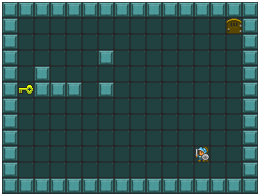

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1143246, Wed Nov  9 08:38:02 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.100000000000000e+01 1.0e+00 4.70e-01  5e-01  5e-01 0:00.1
    2     28 8.200000000000000e+01 1.1e+00 4.52e-01  4e-01  5e-01 0:00.3
    3     42 8.300000000000000e+01 1.1e+00 4.38e-01  4e-01  4e-01 0:00.4
   27    378 6.300000000000000e+01 1.6e+00 5.29e-01  5e-01  6e-01 0:03.4
   54    756 5.800000000000000e+01 2.0e+00 5.25e-01  5e-01  6e-01 0:07.6
   92   1288 5.500000000000000e+01 2.4e+00 3.88e-01  4e-01  4e-01 0:12.6
  100   1400 5.500000000000000e+01 2.5e+00 3.28e-01  3e-01  4e-01 0:13.7
  109   1526 5.500000000000000e+01 2.6e+00 2.88e-01  3e-01  3e-01 0:14.7
  110   1540 5.500000000000000e+01 2.5e+00 2.83e-01  3e-01  3e-01 0:14.8
  117   1638 5.500000000000000e+01 2.6e+00 2.53e-01  2e-01  3e-01 0:15.9
  120   1680 5.500000000000000e+01 2.6e+00 2.40e-01  2e-01  3e-01 0:16.3
  121   1694 5.500000000000000e+

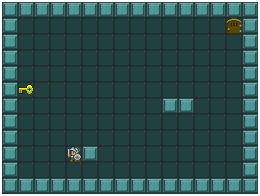

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1084242, Wed Nov  9 08:38:23 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.70e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.46e-01  4e-01  4e-01 0:00.4
    3     42 1.000000000000000e+02 1.1e+00 4.29e-01  4e-01  4e-01 0:00.5
    4     56 1.000000000000000e+02 1.1e+00 4.12e-01  4e-01  4e-01 0:00.6
    5     70 1.000000000000000e+02 1.1e+00 4.02e-01  4e-01  4e-01 0:00.7
    6     84 1.000000000000000e+02 1.1e+00 4.02e-01  4e-01  4e-01 0:00.9
    7     98 1.000000000000000e+02 1.1e+00 3.91e-01  4e-01  4e-01 0:01.0
    8    112 1.000000000000000e+02 1.2e+00 3.79e-01  4e-01  4e-01 0:01.1
    9    126 1.000000000000000e+02 1.2e+00 3.71e-01  4e-01  4e-01 0:01.2
   10    140 1.000000000000000e+02 1.2e+00 3.70e-01  4e-01  4e-01 0:01.3
   11    154 1.000000000000000e+02 1.2e+00 3.66e-01  4e-01  4e-01 0:01.4
   12    168 1.000000000000000e+

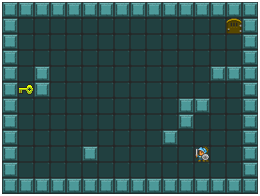

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1013274, Wed Nov  9 08:38:40 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 9.300000000000000e+01 1.0e+00 4.73e-01  5e-01  5e-01 0:00.1
    2     28 9.300000000000000e+01 1.1e+00 4.58e-01  5e-01  5e-01 0:00.3
    3     42 8.700000000000000e+01 1.1e+00 4.55e-01  5e-01  5e-01 0:00.4
   31    434 6.800000000000000e+01 2.0e+00 7.88e-01  8e-01  1e+00 0:03.4
   61    854 6.200000000000000e+01 2.2e+00 6.51e-01  6e-01  8e-01 0:07.5
  100   1400 6.100000000000000e+01 2.5e+00 5.69e-01  5e-01  7e-01 0:12.0
  148   2072 5.600000000000000e+01 2.9e+00 1.09e+00  1e+00  1e+00 0:18.0


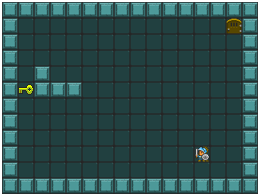

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1095199, Wed Nov  9 08:38:58 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.69e-01  5e-01  5e-01 0:00.1
    2     28 9.500000000000000e+01 1.1e+00 4.42e-01  4e-01  4e-01 0:00.3
    3     42 1.000000000000000e+02 1.1e+00 4.28e-01  4e-01  4e-01 0:00.4
    5     70 1.000000000000000e+02 1.1e+00 4.14e-01  4e-01  4e-01 0:00.7
    6     84 1.000000000000000e+02 1.1e+00 4.10e-01  4e-01  4e-01 0:00.8
    7     98 1.000000000000000e+02 1.1e+00 4.09e-01  4e-01  4e-01 0:00.9
   12    168 1.000000000000000e+02 1.2e+00 4.03e-01  4e-01  4e-01 0:01.4
   13    182 1.000000000000000e+02 1.2e+00 4.03e-01  4e-01  4e-01 0:01.5
   14    196 1.000000000000000e+02 1.2e+00 3.97e-01  4e-01  4e-01 0:01.6
   15    210 1.000000000000000e+02 1.2e+00 3.90e-01  4e-01  4e-01 0:01.7
   16    224 1.000000000000000e+02 1.3e+00 3.91e-01  4e-01  4e-01 0:01.8
   17    238 1.000000000000000e+

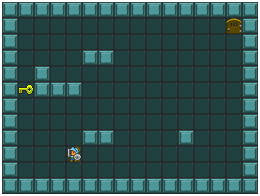

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1085387, Wed Nov  9 08:39:16 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.69e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.55e-01  4e-01  5e-01 0:00.3
    3     42 1.000000000000000e+02 1.1e+00 4.46e-01  4e-01  5e-01 0:00.3
    4     56 1.000000000000000e+02 1.1e+00 4.47e-01  4e-01  5e-01 0:00.4
    5     70 1.000000000000000e+02 1.1e+00 4.50e-01  4e-01  5e-01 0:00.5
   56    784 6.700000000000000e+01 2.2e+00 6.41e-01  6e-01  8e-01 0:05.6
  100   1400 6.500000000000000e+01 2.5e+00 4.01e-01  4e-01  5e-01 0:10.9
  102   1428 6.500000000000000e+01 2.5e+00 3.95e-01  4e-01  5e-01 0:11.1
  103   1442 6.500000000000000e+01 2.5e+00 3.92e-01  4e-01  5e-01 0:11.2
  104   1456 6.500000000000000e+01 2.5e+00 3.87e-01  3e-01  5e-01 0:11.3


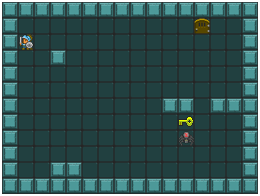

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1073995, Wed Nov  9 08:39:33 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.800000000000000e+01 1.0e+00 4.64e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.42e-01  4e-01  4e-01 0:00.3
    3     42 9.300000000000000e+01 1.1e+00 4.21e-01  4e-01  4e-01 0:00.4
   26    364 6.800000000000000e+01 1.7e+00 6.33e-01  6e-01  7e-01 0:03.4
   63    882 6.000000000000000e+01 1.9e+00 4.46e-01  4e-01  5e-01 0:07.5
  100   1400 5.900000000000000e+01 2.1e+00 2.66e-01  2e-01  3e-01 0:12.2
  110   1540 5.900000000000000e+01 2.1e+00 2.60e-01  2e-01  3e-01 0:13.2
  120   1680 5.900000000000000e+01 2.1e+00 2.63e-01  2e-01  3e-01 0:14.2
  135   1890 5.900000000000000e+01 2.1e+00 2.67e-01  2e-01  3e-01 0:15.9


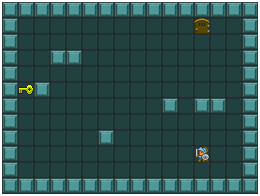

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1080560, Wed Nov  9 08:39:51 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.000000000000000e+01 1.0e+00 4.76e-01  5e-01  5e-01 0:00.1
    2     28 8.400000000000000e+01 1.1e+00 4.63e-01  5e-01  5e-01 0:00.3
    3     42 8.800000000000000e+01 1.1e+00 4.57e-01  5e-01  5e-01 0:00.4
   29    406 6.400000000000000e+01 1.6e+00 5.16e-01  5e-01  5e-01 0:03.5
   63    882 6.100000000000000e+01 2.0e+00 3.72e-01  3e-01  4e-01 0:07.5
   98   1372 6.000000000000000e+01 2.2e+00 2.34e-01  2e-01  3e-01 0:11.8
  100   1400 6.000000000000000e+01 2.2e+00 2.27e-01  2e-01  3e-01 0:12.1
  103   1442 6.000000000000000e+01 2.2e+00 2.12e-01  2e-01  2e-01 0:12.4
  114   1596 6.000000000000000e+01 2.2e+00 2.21e-01  2e-01  2e-01 0:14.1
  115   1610 6.000000000000000e+01 2.2e+00 2.21e-01  2e-01  2e-01 0:14.2
  123   1722 6.000000000000000e+01 2.3e+00 2.26e-01  2e-01  2e-01 0:15.0
  126   1764 6.000000000000000e+

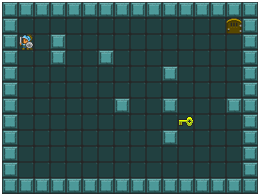

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1035201, Wed Nov  9 08:40:10 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.69e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.54e-01  5e-01  5e-01 0:00.3
    3     42 1.000000000000000e+02 1.1e+00 4.53e-01  4e-01  5e-01 0:00.4
   32    448 6.500000000000000e+01 1.8e+00 5.85e-01  6e-01  6e-01 0:03.4
   65    910 6.200000000000000e+01 2.6e+00 7.51e-01  7e-01  9e-01 0:07.5
   99   1386 6.000000000000000e+01 2.9e+00 6.08e-01  6e-01  7e-01 0:12.6
  100   1400 6.000000000000000e+01 2.9e+00 6.15e-01  6e-01  7e-01 0:12.7
  147   2058 5.900000000000000e+01 3.2e+00 4.57e-01  4e-01  6e-01 0:19.8


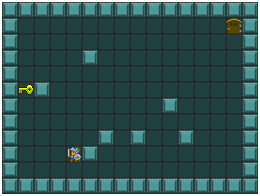

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1040638, Wed Nov  9 08:40:31 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 9.800000000000000e+01 1.0e+00 4.65e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.35e-01  4e-01  4e-01 0:00.3
    3     42 1.000000000000000e+02 1.1e+00 4.15e-01  4e-01  4e-01 0:00.4
    5     70 1.000000000000000e+02 1.1e+00 4.10e-01  4e-01  4e-01 0:00.8
    6     84 1.000000000000000e+02 1.1e+00 4.04e-01  4e-01  4e-01 0:01.1
    7     98 1.000000000000000e+02 1.1e+00 4.02e-01  4e-01  4e-01 0:01.2
   10    140 1.000000000000000e+02 1.2e+00 4.11e-01  4e-01  4e-01 0:01.5
   11    154 1.000000000000000e+02 1.2e+00 4.24e-01  4e-01  4e-01 0:01.5
   12    168 1.000000000000000e+02 1.3e+00 4.33e-01  4e-01  4e-01 0:01.6
   13    182 1.000000000000000e+02 1.3e+00 4.38e-01  4e-01  4e-01 0:01.8
   14    196 1.000000000000000e+02 1.3e+00 4.47e-01  4e-01  5e-01 0:01.9
   15    210 1.000000000000000e+

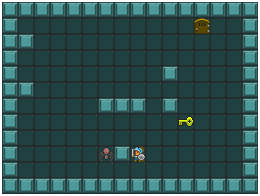

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1127779, Wed Nov  9 08:40:49 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.62e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.40e-01  4e-01  4e-01 0:00.3
    3     42 1.000000000000000e+02 1.1e+00 4.27e-01  4e-01  4e-01 0:00.4
    4     56 1.000000000000000e+02 1.1e+00 4.18e-01  4e-01  4e-01 0:00.5
    5     70 1.000000000000000e+02 1.1e+00 4.17e-01  4e-01  4e-01 0:00.6
    6     84 1.000000000000000e+02 1.1e+00 4.12e-01  4e-01  4e-01 0:00.7
    7     98 1.000000000000000e+02 1.1e+00 4.09e-01  4e-01  4e-01 0:00.8
    8    112 1.000000000000000e+02 1.1e+00 4.08e-01  4e-01  4e-01 0:00.9
    9    126 1.000000000000000e+02 1.2e+00 4.00e-01  4e-01  4e-01 0:01.0
   10    140 1.000000000000000e+02 1.2e+00 3.94e-01  4e-01  4e-01 0:01.1
   11    154 1.000000000000000e+02 1.2e+00 3.80e-01  4e-01  4e-01 0:01.2
   12    168 1.000000000000000e+

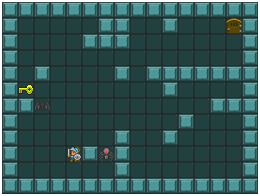

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1061952, Wed Nov  9 08:41:05 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.300000000000000e+01 1.0e+00 4.65e-01  5e-01  5e-01 0:00.1
    2     28 9.500000000000000e+01 1.1e+00 4.50e-01  4e-01  5e-01 0:00.3
    3     42 8.400000000000000e+01 1.1e+00 4.52e-01  4e-01  5e-01 0:00.4
   32    448 7.100000000000000e+01 1.8e+00 6.00e-01  6e-01  7e-01 0:03.5
   69    966 5.800000000000000e+01 2.2e+00 7.93e-01  7e-01  9e-01 0:07.5
  100   1400 5.400000000000000e+01 2.2e+00 6.13e-01  6e-01  7e-01 0:10.8
  125   1750 5.400000000000000e+01 2.3e+00 3.98e-01  4e-01  4e-01 0:13.5
  128   1792 5.400000000000000e+01 2.3e+00 3.60e-01  3e-01  4e-01 0:13.8
  131   1834 5.400000000000000e+01 2.3e+00 3.44e-01  3e-01  4e-01 0:14.3
  132   1848 5.400000000000000e+01 2.3e+00 3.41e-01  3e-01  4e-01 0:14.4
  133   1862 5.400000000000000e+01 2.3e+00 3.40e-01  3e-01  4e-01 0:14.5
  134   1876 5.400000000000000e+

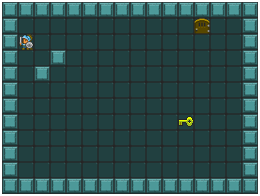

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1112045, Wed Nov  9 08:41:21 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.70e-01  5e-01  5e-01 0:00.1
    2     28 9.200000000000000e+01 1.1e+00 4.53e-01  4e-01  5e-01 0:00.3
    3     42 9.000000000000000e+01 1.1e+00 4.53e-01  4e-01  5e-01 0:00.4
   32    448 7.000000000000000e+01 1.6e+00 4.57e-01  4e-01  5e-01 0:03.4
   65    910 6.300000000000000e+01 1.9e+00 3.65e-01  3e-01  4e-01 0:07.5
   96   1344 6.100000000000000e+01 2.1e+00 2.16e-01  2e-01  2e-01 0:11.1
  100   1400 6.100000000000000e+01 2.1e+00 2.00e-01  2e-01  2e-01 0:11.8
  105   1470 6.100000000000000e+01 2.2e+00 1.67e-01  1e-01  2e-01 0:12.3
  106   1484 6.100000000000000e+01 2.2e+00 1.66e-01  1e-01  2e-01 0:12.4
  107   1498 6.100000000000000e+01 2.2e+00 1.67e-01  1e-01  2e-01 0:12.5
  110   1540 6.100000000000000e+01 2.2e+00 1.76e-01  2e-01  2e-01 0:12.9
  111   1554 6.100000000000000e+

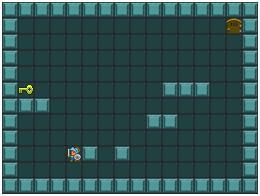

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1041762, Wed Nov  9 08:41:40 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 9.200000000000000e+01 1.0e+00 4.72e-01  5e-01  5e-01 0:00.1
    2     28 7.900000000000000e+01 1.1e+00 4.51e-01  4e-01  5e-01 0:00.4
    3     42 8.300000000000000e+01 1.1e+00 4.46e-01  4e-01  4e-01 0:00.5
   34    476 6.500000000000000e+01 1.6e+00 5.27e-01  5e-01  6e-01 0:03.6
   69    966 6.100000000000000e+01 1.9e+00 3.92e-01  4e-01  4e-01 0:07.7
  100   1400 6.000000000000000e+01 2.1e+00 2.98e-01  3e-01  3e-01 0:11.2
  111   1554 6.000000000000000e+01 2.1e+00 2.56e-01  2e-01  3e-01 0:12.5


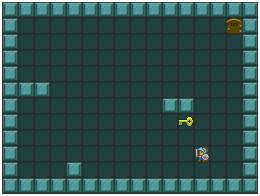

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1133921, Wed Nov  9 08:41:57 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.900000000000000e+01 1.0e+00 4.76e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.62e-01  5e-01  5e-01 0:00.3
    3     42 1.000000000000000e+02 1.1e+00 4.54e-01  4e-01  5e-01 0:00.4
    4     56 1.000000000000000e+02 1.1e+00 4.44e-01  4e-01  4e-01 0:00.5
    5     70 1.000000000000000e+02 1.1e+00 4.38e-01  4e-01  4e-01 0:00.5
    6     84 1.000000000000000e+02 1.1e+00 4.33e-01  4e-01  4e-01 0:00.6
   54    756 7.000000000000000e+01 2.1e+00 7.91e-01  7e-01  1e+00 0:06.7
  100   1400 6.200000000000000e+01 2.5e+00 5.64e-01  5e-01  7e-01 0:12.8
  128   1792 6.200000000000000e+01 2.6e+00 3.84e-01  3e-01  5e-01 0:17.0
  129   1806 6.200000000000000e+01 2.6e+00 3.81e-01  3e-01  5e-01 0:17.2
  132   1848 6.200000000000000e+01 2.6e+00 3.57e-01  3e-01  4e-01 0:17.7
  133   1862 6.200000000000000e+

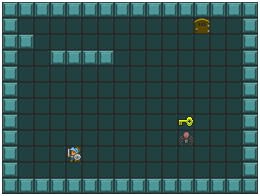

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1067873, Wed Nov  9 08:42:18 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.800000000000000e+01 1.0e+00 4.74e-01  5e-01  5e-01 0:00.1
    2     28 8.100000000000000e+01 1.1e+00 4.64e-01  5e-01  5e-01 0:00.3
    3     42 8.000000000000000e+01 1.1e+00 4.59e-01  5e-01  5e-01 0:00.5
   27    378 6.400000000000000e+01 1.6e+00 6.71e-01  6e-01  7e-01 0:03.5
   55    770 5.800000000000000e+01 2.0e+00 6.23e-01  6e-01  7e-01 0:07.6
   94   1316 5.400000000000000e+01 2.5e+00 5.71e-01  5e-01  7e-01 0:12.6
  100   1400 5.400000000000000e+01 2.5e+00 5.59e-01  5e-01  7e-01 0:13.5
  122   1708 5.400000000000000e+01 2.7e+00 4.40e-01  4e-01  5e-01 0:15.9
  123   1722 5.400000000000000e+01 2.7e+00 4.35e-01  4e-01  5e-01 0:16.1
  126   1764 5.400000000000000e+01 2.7e+00 3.99e-01  3e-01  5e-01 0:16.4
  127   1778 5.400000000000000e+01 2.7e+00 3.91e-01  3e-01  5e-01 0:16.5
  128   1792 5.400000000000000e+

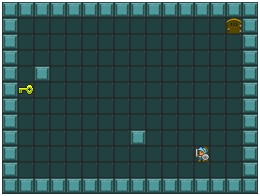

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1077116, Wed Nov  9 08:42:38 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 9.000000000000000e+01 1.0e+00 4.62e-01  5e-01  5e-01 0:00.1
    2     28 8.800000000000000e+01 1.1e+00 4.47e-01  4e-01  5e-01 0:00.3
    3     42 8.600000000000000e+01 1.1e+00 4.38e-01  4e-01  4e-01 0:00.4
   33    462 7.400000000000000e+01 1.6e+00 3.99e-01  4e-01  4e-01 0:03.6
   64    896 7.300000000000000e+01 2.0e+00 2.97e-01  3e-01  3e-01 0:07.6
   70    980 7.300000000000000e+01 2.0e+00 2.68e-01  2e-01  3e-01 0:09.0
   75   1050 7.300000000000000e+01 2.0e+00 2.72e-01  2e-01  3e-01 0:09.9
   85   1190 7.300000000000000e+01 2.1e+00 2.70e-01  2e-01  3e-01 0:10.9
   86   1204 7.300000000000000e+01 2.1e+00 2.69e-01  2e-01  3e-01 0:11.0
   87   1218 7.300000000000000e+01 2.1e+00 2.67e-01  2e-01  3e-01 0:11.1
   88   1232 7.300000000000000e+01 2.1e+00 2.69e-01  2e-01  3e-01 0:11.2
  100   1400 7.200000000000000e+

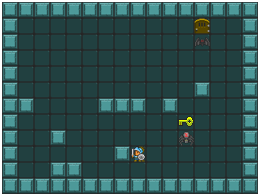

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1129734, Wed Nov  9 08:42:57 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.200000000000000e+01 1.0e+00 4.75e-01  5e-01  5e-01 0:00.1
    2     28 7.400000000000000e+01 1.1e+00 4.58e-01  5e-01  5e-01 0:00.3
    3     42 7.500000000000000e+01 1.1e+00 4.56e-01  5e-01  5e-01 0:00.4
   31    434 6.200000000000000e+01 1.5e+00 4.27e-01  4e-01  4e-01 0:03.5
   68    952 5.900000000000000e+01 1.9e+00 2.59e-01  2e-01  3e-01 0:07.5
  100   1400 5.900000000000000e+01 2.0e+00 2.63e-01  2e-01  3e-01 0:11.6
  126   1764 5.900000000000000e+01 2.2e+00 2.38e-01  2e-01  3e-01 0:14.7
  141   1974 5.900000000000000e+01 2.4e+00 2.60e-01  2e-01  3e-01 0:16.8
  142   1988 5.900000000000000e+01 2.4e+00 2.54e-01  2e-01  3e-01 0:16.9
  143   2002 5.900000000000000e+01 2.4e+00 2.51e-01  2e-01  3e-01 0:17.1
  144   2016 5.900000000000000e+01 2.4e+00 2.39e-01  2e-01  3e-01 0:17.2
  145   2030 5.900000000000000e+

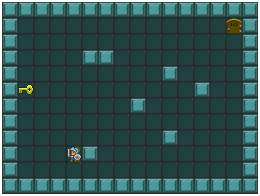

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1098554, Wed Nov  9 08:43:16 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.400000000000000e+01 1.0e+00 4.70e-01  5e-01  5e-01 0:00.1
    2     28 7.600000000000000e+01 1.1e+00 4.60e-01  5e-01  5e-01 0:00.3
    3     42 7.500000000000000e+01 1.1e+00 4.62e-01  5e-01  5e-01 0:00.5
   27    378 6.300000000000000e+01 1.5e+00 5.16e-01  5e-01  5e-01 0:03.6
   57    798 6.100000000000000e+01 1.7e+00 3.91e-01  4e-01  4e-01 0:07.7
   95   1330 5.900000000000000e+01 1.9e+00 2.59e-01  2e-01  3e-01 0:12.8
  100   1400 5.900000000000000e+01 1.9e+00 2.46e-01  2e-01  3e-01 0:13.6
  104   1456 5.900000000000000e+01 1.9e+00 2.25e-01  2e-01  2e-01 0:14.0
  123   1722 5.800000000000000e+01 2.0e+00 1.95e-01  2e-01  2e-01 0:16.6
  126   1764 5.800000000000000e+01 2.0e+00 1.88e-01  2e-01  2e-01 0:17.2
  134   1876 5.800000000000000e+01 2.0e+00 1.75e-01  2e-01  2e-01 0:18.7
  137   1918 5.800000000000000e+

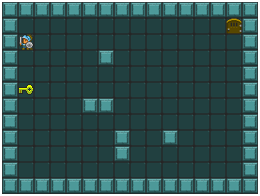

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1021258, Wed Nov  9 08:43:39 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 9.500000000000000e+01 1.0e+00 4.70e-01  5e-01  5e-01 0:00.1
    2     28 9.400000000000000e+01 1.1e+00 4.48e-01  4e-01  5e-01 0:00.3
    3     42 9.000000000000000e+01 1.1e+00 4.40e-01  4e-01  4e-01 0:00.4
   32    448 6.500000000000000e+01 1.9e+00 9.93e-01  1e+00  1e+00 0:03.5
   62    868 5.900000000000000e+01 2.3e+00 1.28e+00  1e+00  2e+00 0:07.5
  100   1400 5.800000000000000e+01 2.9e+00 1.10e+00  1e+00  1e+00 0:12.5
  149   2086 5.400000000000000e+01 3.1e+00 9.61e-01  9e-01  1e+00 0:18.5


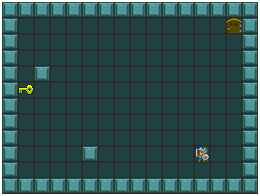

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1073521, Wed Nov  9 08:43:58 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.500000000000000e+01 1.0e+00 4.78e-01  5e-01  5e-01 0:00.1
    2     28 8.200000000000000e+01 1.1e+00 4.75e-01  5e-01  5e-01 0:00.4
    3     42 8.100000000000000e+01 1.1e+00 4.79e-01  5e-01  5e-01 0:00.5
   30    420 5.800000000000000e+01 1.9e+00 9.93e-01  1e+00  1e+00 0:03.5
   64    896 5.700000000000000e+01 2.5e+00 7.85e-01  7e-01  1e+00 0:07.5
   99   1386 5.600000000000000e+01 2.6e+00 5.97e-01  5e-01  8e-01 0:12.4
  100   1400 5.600000000000000e+01 2.6e+00 5.90e-01  5e-01  7e-01 0:12.5
  101   1414 5.600000000000000e+01 2.6e+00 5.77e-01  5e-01  7e-01 0:12.6
  106   1484 5.600000000000000e+01 2.6e+00 5.21e-01  5e-01  7e-01 0:13.2
  107   1498 5.600000000000000e+01 2.6e+00 5.12e-01  4e-01  7e-01 0:13.3
  108   1512 5.600000000000000e+01 2.6e+00 5.04e-01  4e-01  6e-01 0:13.4
  109   1526 5.600000000000000e+

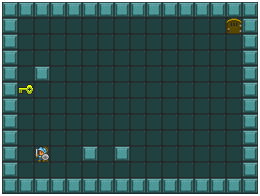

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1046562, Wed Nov  9 08:44:17 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.400000000000000e+01 1.0e+00 4.73e-01  5e-01  5e-01 0:00.1
    2     28 8.200000000000000e+01 1.1e+00 4.55e-01  4e-01  5e-01 0:00.3
    3     42 7.600000000000000e+01 1.1e+00 4.54e-01  4e-01  5e-01 0:00.4
   31    434 6.400000000000000e+01 1.5e+00 4.72e-01  5e-01  5e-01 0:03.5
   67    938 5.700000000000000e+01 1.7e+00 3.65e-01  3e-01  4e-01 0:07.6
  100   1400 5.700000000000000e+01 1.9e+00 2.05e-01  2e-01  2e-01 0:12.0
  121   1694 5.700000000000000e+01 2.0e+00 2.04e-01  2e-01  2e-01 0:14.1
  140   1960 5.700000000000000e+01 2.1e+00 1.69e-01  1e-01  2e-01 0:16.4
  144   2016 5.700000000000000e+01 2.1e+00 1.57e-01  1e-01  2e-01 0:16.9
  145   2030 5.700000000000000e+01 2.1e+00 1.59e-01  1e-01  2e-01 0:17.0
  146   2044 5.700000000000000e+01 2.1e+00 1.57e-01  1e-01  2e-01 0:17.1


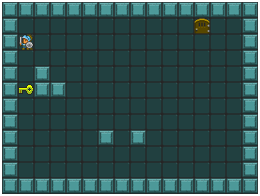

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1069954, Wed Nov  9 08:44:35 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.800000000000000e+01 1.0e+00 4.70e-01  5e-01  5e-01 0:00.1
    2     28 7.500000000000000e+01 1.1e+00 4.54e-01  4e-01  5e-01 0:00.3
    3     42 7.700000000000000e+01 1.1e+00 4.39e-01  4e-01  4e-01 0:00.4
   32    448 6.300000000000000e+01 1.5e+00 3.93e-01  4e-01  4e-01 0:03.5
   69    966 5.900000000000000e+01 1.9e+00 3.06e-01  3e-01  3e-01 0:07.5
   73   1022 5.900000000000000e+01 2.0e+00 2.82e-01  3e-01  3e-01 0:08.0
   87   1218 5.900000000000000e+01 2.1e+00 2.29e-01  2e-01  2e-01 0:09.5
   97   1358 5.900000000000000e+01 2.1e+00 1.95e-01  2e-01  2e-01 0:10.5
  100   1400 5.900000000000000e+01 2.1e+00 1.84e-01  2e-01  2e-01 0:11.1
  103   1442 5.900000000000000e+01 2.1e+00 1.77e-01  2e-01  2e-01 0:11.5
  104   1456 5.900000000000000e+01 2.1e+00 1.78e-01  2e-01  2e-01 0:11.6
  105   1470 5.900000000000000e+

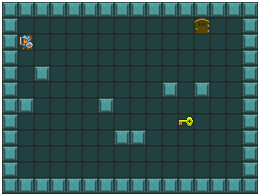

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1108008, Wed Nov  9 08:44:53 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 9.300000000000000e+01 1.0e+00 4.72e-01  5e-01  5e-01 0:00.1
    2     28 8.700000000000000e+01 1.1e+00 4.56e-01  5e-01  5e-01 0:00.3
    3     42 9.000000000000000e+01 1.1e+00 4.45e-01  4e-01  4e-01 0:00.5
   31    434 7.100000000000000e+01 1.8e+00 5.26e-01  5e-01  6e-01 0:03.6
   65    910 6.700000000000000e+01 2.1e+00 3.47e-01  3e-01  4e-01 0:07.6
   88   1232 6.700000000000000e+01 2.4e+00 3.09e-01  3e-01  4e-01 0:10.2
   91   1274 6.700000000000000e+01 2.4e+00 2.81e-01  3e-01  3e-01 0:10.6
   94   1316 6.700000000000000e+01 2.4e+00 2.84e-01  3e-01  3e-01 0:10.9
   99   1386 6.700000000000000e+01 2.5e+00 3.30e-01  3e-01  4e-01 0:11.6
  100   1400 6.700000000000000e+01 2.5e+00 3.39e-01  3e-01  4e-01 0:11.7
  111   1554 6.700000000000000e+01 2.5e+00 3.39e-01  3e-01  4e-01 0:13.0
  112   1568 6.700000000000000e+

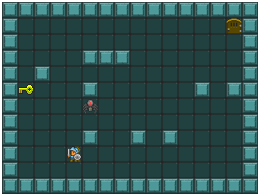

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1135554, Wed Nov  9 08:45:11 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.500000000000000e+01 1.0e+00 4.71e-01  5e-01  5e-01 0:00.1
    2     28 8.900000000000000e+01 1.1e+00 4.55e-01  5e-01  5e-01 0:00.3
    3     42 8.100000000000000e+01 1.1e+00 4.43e-01  4e-01  4e-01 0:00.4
   33    462 6.000000000000000e+01 1.8e+00 5.53e-01  5e-01  6e-01 0:03.5
   65    910 5.500000000000000e+01 2.6e+00 7.42e-01  7e-01  1e+00 0:07.5
  100   1400 5.500000000000000e+01 3.2e+00 5.86e-01  5e-01  8e-01 0:11.4
  101   1414 5.500000000000000e+01 3.2e+00 5.78e-01  5e-01  8e-01 0:11.5
  102   1428 5.500000000000000e+01 3.2e+00 5.76e-01  5e-01  8e-01 0:11.7
  103   1442 5.500000000000000e+01 3.2e+00 5.72e-01  5e-01  8e-01 0:11.8
  109   1526 5.500000000000000e+01 3.3e+00 5.43e-01  5e-01  8e-01 0:12.5
  113   1582 5.500000000000000e+01 3.3e+00 5.40e-01  5e-01  8e-01 0:13.0
  119   1666 5.500000000000000e+

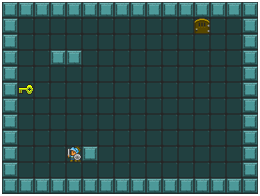

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=999983, Wed Nov  9 08:45:30 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.76e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.67e-01  5e-01  5e-01 0:00.3
    3     42 1.000000000000000e+02 1.1e+00 4.63e-01  5e-01  5e-01 0:00.4
    4     56 1.000000000000000e+02 1.1e+00 4.53e-01  4e-01  5e-01 0:00.5
    5     70 1.000000000000000e+02 1.1e+00 4.54e-01  4e-01  5e-01 0:00.6
    6     84 1.000000000000000e+02 1.2e+00 4.56e-01  4e-01  5e-01 0:00.6
    7     98 1.000000000000000e+02 1.2e+00 4.57e-01  4e-01  5e-01 0:00.7
    8    112 1.000000000000000e+02 1.2e+00 4.57e-01  4e-01  5e-01 0:00.8
    9    126 1.000000000000000e+02 1.2e+00 4.57e-01  4e-01  5e-01 0:00.9
   10    140 1.000000000000000e+02 1.2e+00 4.51e-01  4e-01  5e-01 0:01.0
   11    154 1.000000000000000e+02 1.2e+00 4.52e-01  4e-01  5e-01 0:01.1
   12    168 1.000000000000000e+0

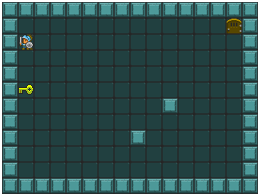

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1055103, Wed Nov  9 08:45:47 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 9.000000000000000e+01 1.0e+00 4.60e-01  5e-01  5e-01 0:00.1
    2     28 9.100000000000000e+01 1.1e+00 4.38e-01  4e-01  4e-01 0:00.3
    3     42 9.400000000000000e+01 1.1e+00 4.25e-01  4e-01  4e-01 0:00.4
   29    406 6.100000000000000e+01 1.7e+00 6.03e-01  6e-01  7e-01 0:03.4
   66    924 5.500000000000000e+01 2.2e+00 7.64e-01  7e-01  9e-01 0:07.6
  100   1400 5.300000000000000e+01 2.6e+00 5.55e-01  5e-01  6e-01 0:12.2
  109   1526 5.300000000000000e+01 2.7e+00 4.81e-01  4e-01  6e-01 0:13.3
  124   1736 5.300000000000000e+01 2.8e+00 3.57e-01  3e-01  4e-01 0:15.1
  125   1750 5.300000000000000e+01 2.8e+00 3.57e-01  3e-01  4e-01 0:15.2
  126   1764 5.300000000000000e+01 2.8e+00 3.51e-01  3e-01  4e-01 0:15.4
  129   1806 5.300000000000000e+01 2.8e+00 3.54e-01  3e-01  4e-01 0:15.8
  130   1820 5.300000000000000e+

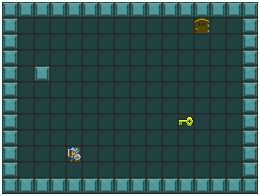

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1092549, Wed Nov  9 08:46:06 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 9.400000000000000e+01 1.0e+00 4.70e-01  5e-01  5e-01 0:00.1
    2     28 8.800000000000000e+01 1.1e+00 4.53e-01  4e-01  5e-01 0:00.4
    3     42 8.700000000000000e+01 1.1e+00 4.41e-01  4e-01  4e-01 0:00.5
   26    364 7.500000000000000e+01 1.3e+00 2.68e-01  3e-01  3e-01 0:03.5
   59    826 6.900000000000000e+01 1.5e+00 2.15e-01  2e-01  2e-01 0:07.7
  100   1400 6.300000000000000e+01 1.7e+00 1.35e-01  1e-01  1e-01 0:12.5
  130   1820 6.300000000000000e+01 1.9e+00 9.45e-02  8e-02  1e-01 0:16.3
  137   1918 6.300000000000000e+01 1.9e+00 8.92e-02  8e-02  9e-02 0:17.0
  138   1932 6.300000000000000e+01 1.9e+00 8.85e-02  8e-02  9e-02 0:17.2
  141   1974 6.300000000000000e+01 1.9e+00 8.50e-02  8e-02  9e-02 0:17.5
  142   1988 6.300000000000000e+01 1.9e+00 8.43e-02  7e-02  9e-02 0:17.6
  143   2002 6.300000000000000e+

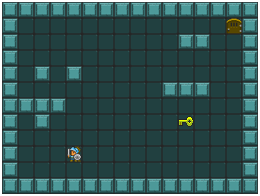

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1125140, Wed Nov  9 08:46:25 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.900000000000000e+01 1.0e+00 4.63e-01  5e-01  5e-01 0:00.1
    2     28 8.900000000000000e+01 1.1e+00 4.42e-01  4e-01  4e-01 0:00.3
    3     42 8.500000000000000e+01 1.1e+00 4.36e-01  4e-01  4e-01 0:00.4
   30    420 7.000000000000000e+01 1.6e+00 6.27e-01  6e-01  7e-01 0:03.5
   68    952 6.300000000000000e+01 1.9e+00 4.76e-01  4e-01  5e-01 0:07.5
   97   1358 6.200000000000000e+01 2.2e+00 3.49e-01  3e-01  4e-01 0:10.6
   98   1372 6.200000000000000e+01 2.2e+00 3.48e-01  3e-01  4e-01 0:10.8
  100   1400 6.200000000000000e+01 2.2e+00 3.42e-01  3e-01  4e-01 0:11.2
  105   1470 6.200000000000000e+01 2.2e+00 3.26e-01  3e-01  3e-01 0:11.7
  106   1484 6.200000000000000e+01 2.2e+00 3.22e-01  3e-01  3e-01 0:11.8
  107   1498 6.200000000000000e+01 2.3e+00 3.25e-01  3e-01  3e-01 0:11.9
  115   1610 6.200000000000000e+

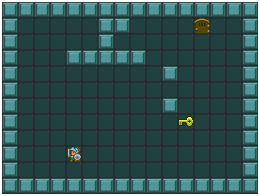

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1081105, Wed Nov  9 08:46:43 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.66e-01  5e-01  5e-01 0:00.1
    2     28 9.500000000000000e+01 1.1e+00 4.45e-01  4e-01  4e-01 0:00.3
    3     42 1.000000000000000e+02 1.1e+00 4.30e-01  4e-01  4e-01 0:00.4
    4     56 1.000000000000000e+02 1.1e+00 4.20e-01  4e-01  4e-01 0:00.5
   36    504 7.100000000000000e+01 2.0e+00 5.36e-01  5e-01  6e-01 0:04.6
   66    924 7.000000000000000e+01 2.3e+00 3.93e-01  4e-01  5e-01 0:08.7
   86   1204 6.900000000000000e+01 2.5e+00 3.12e-01  3e-01  4e-01 0:11.5
   87   1218 6.900000000000000e+01 2.5e+00 2.94e-01  3e-01  4e-01 0:11.7
   88   1232 6.900000000000000e+01 2.5e+00 2.81e-01  3e-01  3e-01 0:11.9
   89   1246 6.900000000000000e+01 2.6e+00 2.74e-01  2e-01  3e-01 0:12.0
   96   1344 6.900000000000000e+01 2.6e+00 2.26e-01  2e-01  3e-01 0:12.7
   97   1358 6.900000000000000e+

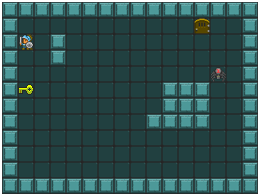

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1039168, Wed Nov  9 08:47:03 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 7.700000000000000e+01 1.0e+00 4.75e-01  5e-01  5e-01 0:00.1
    2     28 8.300000000000000e+01 1.1e+00 4.65e-01  5e-01  5e-01 0:00.3
    3     42 7.400000000000000e+01 1.1e+00 4.61e-01  5e-01  5e-01 0:00.4
   30    420 6.000000000000000e+01 1.8e+00 6.80e-01  6e-01  7e-01 0:03.5
   59    826 5.700000000000000e+01 2.2e+00 9.07e-01  8e-01  1e+00 0:07.7
   91   1274 5.700000000000000e+01 2.5e+00 6.23e-01  6e-01  7e-01 0:12.0
   92   1288 5.700000000000000e+01 2.5e+00 6.27e-01  6e-01  7e-01 0:12.3
  100   1400 5.700000000000000e+01 2.6e+00 6.63e-01  6e-01  8e-01 0:13.9
  114   1596 5.700000000000000e+01 2.7e+00 5.88e-01  5e-01  7e-01 0:15.7
  115   1610 5.700000000000000e+01 2.7e+00 5.77e-01  5e-01  7e-01 0:15.8
  120   1680 5.700000000000000e+01 2.7e+00 4.84e-01  4e-01  6e-01 0:16.8
  121   1694 5.700000000000000e+

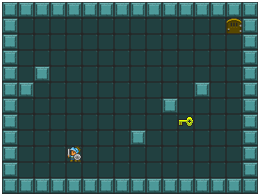

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1103502, Wed Nov  9 08:47:24 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.60e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.35e-01  4e-01  4e-01 0:00.3
    3     42 1.000000000000000e+02 1.1e+00 4.21e-01  4e-01  4e-01 0:00.4
    4     56 1.000000000000000e+02 1.1e+00 4.04e-01  4e-01  4e-01 0:00.6
    5     70 1.000000000000000e+02 1.1e+00 4.04e-01  4e-01  4e-01 0:00.7
    6     84 1.000000000000000e+02 1.1e+00 4.00e-01  4e-01  4e-01 0:00.8
    7     98 1.000000000000000e+02 1.1e+00 3.95e-01  4e-01  4e-01 0:00.8
    8    112 1.000000000000000e+02 1.2e+00 3.84e-01  4e-01  4e-01 0:00.9
    9    126 1.000000000000000e+02 1.2e+00 3.73e-01  4e-01  4e-01 0:01.0
   10    140 1.000000000000000e+02 1.2e+00 3.66e-01  4e-01  4e-01 0:01.1
   11    154 1.000000000000000e+02 1.2e+00 3.65e-01  4e-01  4e-01 0:01.2
   12    168 1.000000000000000e+

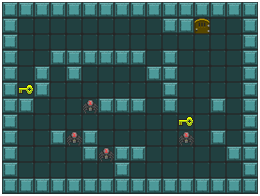

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1048151, Wed Nov  9 08:47:41 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.000000000000000e+01 1.0e+00 4.68e-01  5e-01  5e-01 0:00.1
    2     28 7.900000000000000e+01 1.1e+00 4.44e-01  4e-01  4e-01 0:00.3
    3     42 8.200000000000000e+01 1.1e+00 4.32e-01  4e-01  4e-01 0:00.4
   33    462 6.500000000000000e+01 1.4e+00 3.82e-01  4e-01  4e-01 0:03.4
   64    896 6.100000000000000e+01 1.7e+00 3.12e-01  3e-01  3e-01 0:07.7
   98   1372 6.000000000000000e+01 1.9e+00 1.68e-01  2e-01  2e-01 0:12.5
   99   1386 6.000000000000000e+01 1.9e+00 1.65e-01  2e-01  2e-01 0:12.7
  100   1400 6.000000000000000e+01 1.9e+00 1.59e-01  1e-01  2e-01 0:12.9
  106   1484 6.000000000000000e+01 1.9e+00 1.40e-01  1e-01  1e-01 0:13.9
  107   1498 6.000000000000000e+01 1.9e+00 1.38e-01  1e-01  1e-01 0:14.0
  110   1540 6.000000000000000e+01 1.9e+00 1.24e-01  1e-01  1e-01 0:14.4
  111   1554 6.000000000000000e+

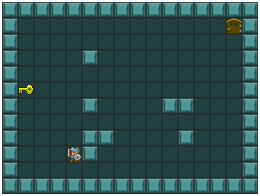

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1073883, Wed Nov  9 08:48:01 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 9.100000000000000e+01 1.0e+00 4.72e-01  5e-01  5e-01 0:00.1
    2     28 9.200000000000000e+01 1.1e+00 4.68e-01  5e-01  5e-01 0:00.3
    3     42 8.200000000000000e+01 1.1e+00 4.68e-01  5e-01  5e-01 0:00.4
   28    392 6.900000000000000e+01 1.4e+00 3.58e-01  3e-01  4e-01 0:03.5
   51    714 6.300000000000000e+01 1.7e+00 3.98e-01  4e-01  4e-01 0:07.6
   90   1260 5.600000000000000e+01 2.0e+00 4.70e-01  4e-01  5e-01 0:12.6
  100   1400 5.600000000000000e+01 2.0e+00 4.21e-01  4e-01  5e-01 0:14.0
  130   1820 5.500000000000000e+01 2.2e+00 2.55e-01  2e-01  3e-01 0:18.2
  135   1890 5.500000000000000e+01 2.2e+00 2.28e-01  2e-01  3e-01 0:18.7
  136   1904 5.500000000000000e+01 2.2e+00 2.24e-01  2e-01  3e-01 0:18.8
  137   1918 5.500000000000000e+01 2.2e+00 2.23e-01  2e-01  3e-01 0:18.9
  138   1932 5.500000000000000e+

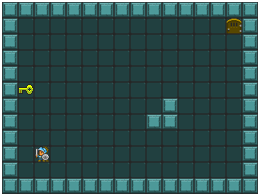

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1046268, Wed Nov  9 08:48:22 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.70e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.51e-01  4e-01  5e-01 0:00.3
    3     42 9.700000000000000e+01 1.1e+00 4.37e-01  4e-01  4e-01 0:00.4
   32    448 7.100000000000000e+01 1.7e+00 5.15e-01  5e-01  5e-01 0:03.5
   67    938 6.300000000000000e+01 2.1e+00 4.19e-01  4e-01  4e-01 0:07.6
   93   1302 6.200000000000000e+01 2.3e+00 3.06e-01  3e-01  3e-01 0:10.5
   94   1316 6.200000000000000e+01 2.3e+00 3.14e-01  3e-01  3e-01 0:10.6
   97   1358 6.200000000000000e+01 2.4e+00 3.18e-01  3e-01  3e-01 0:10.9
   98   1372 6.200000000000000e+01 2.4e+00 3.08e-01  3e-01  3e-01 0:11.1
  100   1400 6.200000000000000e+01 2.4e+00 2.99e-01  3e-01  3e-01 0:11.5
  101   1414 6.200000000000000e+01 2.4e+00 2.96e-01  3e-01  3e-01 0:11.6
  102   1428 6.200000000000000e+

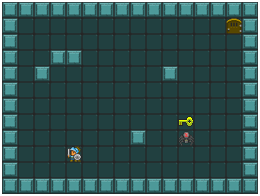

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1119485, Wed Nov  9 08:48:40 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.800000000000000e+01 1.0e+00 4.75e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.57e-01  5e-01  5e-01 0:00.3
    3     42 8.900000000000000e+01 1.1e+00 4.45e-01  4e-01  4e-01 0:00.4
   34    476 6.500000000000000e+01 1.6e+00 4.79e-01  5e-01  5e-01 0:03.5
   71    994 5.800000000000000e+01 2.0e+00 4.01e-01  4e-01  4e-01 0:07.6
  100   1400 5.700000000000000e+01 2.2e+00 3.50e-01  3e-01  4e-01 0:11.3


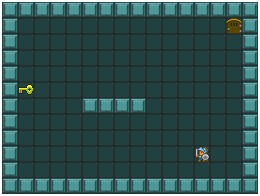

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1147403, Wed Nov  9 08:48:57 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.67e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.50e-01  4e-01  5e-01 0:00.3
    3     42 1.000000000000000e+02 1.1e+00 4.45e-01  4e-01  4e-01 0:00.5
    4     56 1.000000000000000e+02 1.1e+00 4.46e-01  4e-01  5e-01 0:00.6
    5     70 1.000000000000000e+02 1.1e+00 4.41e-01  4e-01  4e-01 0:00.8
    6     84 1.000000000000000e+02 1.2e+00 4.32e-01  4e-01  4e-01 0:00.9
    7     98 1.000000000000000e+02 1.2e+00 4.28e-01  4e-01  4e-01 0:01.0
    8    112 1.000000000000000e+02 1.2e+00 4.24e-01  4e-01  4e-01 0:01.1
    9    126 1.000000000000000e+02 1.2e+00 4.28e-01  4e-01  4e-01 0:01.2
   10    140 1.000000000000000e+02 1.2e+00 4.31e-01  4e-01  4e-01 0:01.3
   11    154 1.000000000000000e+02 1.2e+00 4.33e-01  4e-01  4e-01 0:01.4
   12    168 1.000000000000000e+

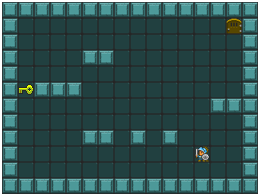

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1107583, Wed Nov  9 08:49:15 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.66e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.52e-01  4e-01  5e-01 0:00.3
    3     42 1.000000000000000e+02 1.1e+00 4.53e-01  4e-01  5e-01 0:00.4
   30    420 5.900000000000000e+01 1.8e+00 9.41e-01  9e-01  1e+00 0:03.4
   64    896 5.600000000000000e+01 2.2e+00 7.16e-01  7e-01  8e-01 0:07.5
   78   1092 5.600000000000000e+01 2.2e+00 6.60e-01  6e-01  7e-01 0:09.9
   94   1316 5.600000000000000e+01 2.4e+00 5.51e-01  5e-01  6e-01 0:12.1
   95   1330 5.600000000000000e+01 2.4e+00 5.48e-01  5e-01  6e-01 0:12.2
   98   1372 5.600000000000000e+01 2.4e+00 5.49e-01  5e-01  6e-01 0:12.7
   99   1386 5.600000000000000e+01 2.4e+00 5.33e-01  5e-01  6e-01 0:12.9
  100   1400 5.600000000000000e+01 2.4e+00 5.27e-01  5e-01  6e-01 0:13.0
  101   1414 5.600000000000000e+

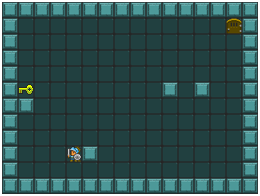

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1103316, Wed Nov  9 08:49:35 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.500000000000000e+01 1.0e+00 4.75e-01  5e-01  5e-01 0:00.1
    2     28 8.900000000000000e+01 1.1e+00 4.50e-01  4e-01  5e-01 0:00.3
    3     42 8.000000000000000e+01 1.1e+00 4.33e-01  4e-01  4e-01 0:00.4
   29    406 6.800000000000000e+01 1.6e+00 4.93e-01  5e-01  5e-01 0:03.4
   57    798 6.200000000000000e+01 1.9e+00 3.62e-01  3e-01  4e-01 0:07.5
   96   1344 6.100000000000000e+01 2.6e+00 5.19e-01  5e-01  6e-01 0:12.6
  100   1400 6.100000000000000e+01 2.6e+00 5.30e-01  5e-01  6e-01 0:13.1
  118   1652 6.100000000000000e+01 2.9e+00 4.99e-01  5e-01  6e-01 0:16.1
  119   1666 6.100000000000000e+01 2.9e+00 4.96e-01  5e-01  6e-01 0:16.3
  120   1680 6.100000000000000e+01 2.9e+00 4.89e-01  4e-01  6e-01 0:16.4
  131   1834 6.100000000000000e+01 3.0e+00 3.78e-01  3e-01  5e-01 0:17.9
  132   1848 6.100000000000000e+

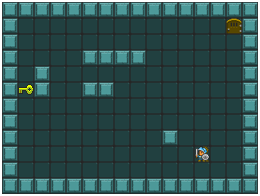

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1065794, Wed Nov  9 08:49:57 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.70e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.50e-01  4e-01  5e-01 0:00.3
    3     42 1.000000000000000e+02 1.1e+00 4.37e-01  4e-01  4e-01 0:00.4
    7     98 1.000000000000000e+02 1.1e+00 4.14e-01  4e-01  4e-01 0:00.8
   10    140 1.000000000000000e+02 1.2e+00 4.23e-01  4e-01  4e-01 0:01.2
   53    742 6.800000000000000e+01 2.0e+00 5.49e-01  5e-01  6e-01 0:06.2
  100   1400 6.000000000000000e+01 2.9e+00 1.02e+00  9e-01  1e+00 0:12.0


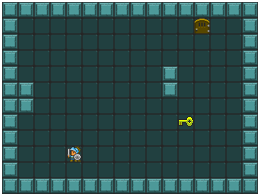

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1085358, Wed Nov  9 08:50:15 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.500000000000000e+01 1.0e+00 4.68e-01  5e-01  5e-01 0:00.1
    2     28 7.600000000000000e+01 1.1e+00 4.51e-01  4e-01  5e-01 0:00.3
    3     42 7.800000000000000e+01 1.1e+00 4.39e-01  4e-01  4e-01 0:00.6
   32    448 6.600000000000000e+01 1.5e+00 3.31e-01  3e-01  4e-01 0:03.6
   66    924 6.100000000000000e+01 1.9e+00 2.63e-01  2e-01  3e-01 0:07.8
  100   1400 5.900000000000000e+01 2.0e+00 2.39e-01  2e-01  3e-01 0:11.7
  122   1708 5.900000000000000e+01 2.2e+00 1.87e-01  2e-01  2e-01 0:14.1
  123   1722 5.900000000000000e+01 2.2e+00 1.83e-01  2e-01  2e-01 0:14.2
  130   1820 5.900000000000000e+01 2.3e+00 1.74e-01  2e-01  2e-01 0:15.1
  133   1862 5.900000000000000e+01 2.4e+00 1.58e-01  1e-01  2e-01 0:15.4
  134   1876 5.900000000000000e+01 2.4e+00 1.54e-01  1e-01  2e-01 0:15.5
  135   1890 5.900000000000000e+

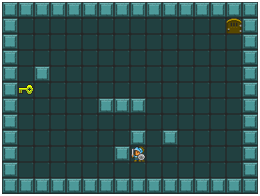

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1124828, Wed Nov  9 08:50:33 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 8.900000000000000e+01 1.0e+00 4.76e-01  5e-01  5e-01 0:00.1
    2     28 9.100000000000000e+01 1.1e+00 4.66e-01  5e-01  5e-01 0:00.3
    3     42 9.100000000000000e+01 1.1e+00 4.50e-01  4e-01  5e-01 0:00.4
   32    448 6.600000000000000e+01 1.8e+00 7.29e-01  7e-01  8e-01 0:03.5
   63    882 6.200000000000000e+01 2.2e+00 8.63e-01  8e-01  1e+00 0:07.5
   95   1330 6.200000000000000e+01 2.4e+00 4.74e-01  4e-01  6e-01 0:11.8
   96   1344 6.200000000000000e+01 2.4e+00 4.59e-01  4e-01  5e-01 0:11.9
   97   1358 6.200000000000000e+01 2.4e+00 4.42e-01  4e-01  5e-01 0:12.0
  100   1400 6.200000000000000e+01 2.4e+00 4.01e-01  4e-01  5e-01 0:12.4
  101   1414 6.200000000000000e+01 2.4e+00 3.98e-01  4e-01  5e-01 0:12.6
  102   1428 6.200000000000000e+01 2.4e+00 4.03e-01  4e-01  5e-01 0:12.7
  103   1442 6.200000000000000e+

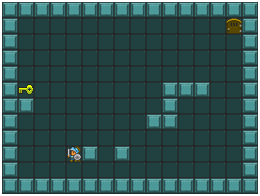

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1000768, Wed Nov  9 08:50:53 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.74e-01  5e-01  5e-01 0:00.1
    2     28 9.500000000000000e+01 1.1e+00 4.64e-01  5e-01  5e-01 0:00.3
    3     42 9.700000000000000e+01 1.1e+00 4.67e-01  5e-01  5e-01 0:00.4
    5     70 1.000000000000000e+02 1.1e+00 4.74e-01  5e-01  5e-01 0:00.5
    6     84 1.000000000000000e+02 1.2e+00 4.83e-01  5e-01  5e-01 0:00.6
   55    770 6.000000000000000e+01 1.9e+00 4.26e-01  4e-01  5e-01 0:05.6
   92   1288 6.000000000000000e+01 2.1e+00 2.14e-01  2e-01  2e-01 0:09.9
   93   1302 6.000000000000000e+01 2.1e+00 2.11e-01  2e-01  2e-01 0:10.0
   94   1316 6.000000000000000e+01 2.1e+00 2.10e-01  2e-01  2e-01 0:10.1
   95   1330 6.000000000000000e+01 2.1e+00 2.08e-01  2e-01  2e-01 0:10.2
   96   1344 6.000000000000000e+01 2.1e+00 2.04e-01  2e-01  2e-01 0:10.3
   97   1358 6.000000000000000e+

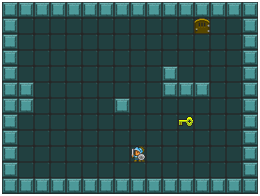

mean score:60.0
mean counts:60.0
mean changes:-37.08163265306123
mean playability:0.98
mean hamming dist:14.756802721088436


In [18]:
# ours2
model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/none-714/latest.tar"
load_model = torch.load(model_path)
generator.load_state_dict(load_model["generator"])
check(generator, fitnessf2)
